# Аппроксимируем эпидемиологические данные (начало эпидемии)

## 1. Подключаем необходимые библиотеки

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize
import pandas as pd
import datetime

## 2. Загружаем данные

Данные о распространении эпидемии возьмем [здесь](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series). Данные обновляются каждый день.

Будем использовать [pandas](https://pandas.pydata.org/) - библиотеку, в которой реализованы полезные инструменты для анализа данных. Основной тип данных в этой библиотеке - это таблицы (`dataframe`).

In [2]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
covid19_confirmed = pd.read_csv(url + "time_series_covid19_confirmed_global.csv")
covid19_deaths    = pd.read_csv(url + "time_series_covid19_deaths_global.csv")
covid19_recovered = pd.read_csv(url + "time_series_covid19_recovered_global.csv")

**Внимание!** *Данные обновляются ежедневно, поэтому вы можете получить другой результат.*

Мы загрузили 3 таблицы, которые содержат данные по странам на данный день:
* `covid19_confirmed` о количестве подтвержденных случаев
* `covid19_deaths`    - суммарное количество
* `covid19_recovered` - суммарное количество выздоровевших

Рассмотрим, например, `covid19_confirmed`:

In [3]:
covid19_confirmed

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20
0,NaN,Afghanistan,33.000000,65.000000,0,0,0,0,0,0,...,3778,4033,4402,4687,4963,5226,5639,6053,6402,6664
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,850,856,868,872,876,880,898,916,933,946
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,5369,5558,5723,5891,6067,6253,6442,6629,6821,7019
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,752,754,755,755,758,760,761,761,761,761
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,43,43,45,45,45,45,48,48,48,48
5,NaN,Antigua and Barbuda,17.060800,-61.796400,0,0,0,0,0,0,...,25,25,25,25,25,25,25,25,25,25
6,NaN,Argentina,-38.416100,-63.616700,0,0,0,0,0,0,...,5611,5776,6034,6278,6563,6879,7134,7479,7805,8068
7,NaN,Armenia,40.069100,45.038200,0,0,0,0,0,0,...,3029,3175,3313,3392,3538,3718,3860,4044,4283,4472
8,Australian Capital Territory,Australia,-35.473500,149.012400,0,0,0,0,0,0,...,107,107,107,107,107,107,107,107,107,107
9,New South Wales,Australia,-33.868800,151.209300,0,0,0,0,3,4,...,3051,3053,3053,3053,3059,3063,3071,3074,3075,3076


Мы видим, что данные по каждой стране или провинции расположены по строкам. `NaN` соответствует пропущенным значениям. Для каждой страны указаны географические координаты, а затем, начиная с 4-го столбца (столбцы нумеруются с нуля) - конкретные значения зарегестрированных случаев.

Названия столбцов можно получить следующим образом:

In [4]:
covid19_confirmed.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       ...
       '5/8/20', '5/9/20', '5/10/20', '5/11/20', '5/12/20', '5/13/20',
       '5/14/20', '5/15/20', '5/16/20', '5/17/20'],
      dtype='object', length=121)

Извлечь данные по конкретной стране можно так:

In [5]:
covid19_confirmed[covid19_confirmed['Country/Region']=='Russia']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20
187,NaN,Russia,60.0,90.0,0,0,0,0,0,0,...,187859,198676,209688,221344,232243,242271,252245,262843,272043,281752


Скопируем данные для России, получим три `numpy`-массива:

In [6]:
Russia_confirmed = np.array(covid19_confirmed[covid19_confirmed['Country/Region']=='Russia'].iloc[0,4:], dtype=float)
Russia_deaths    = np.array(covid19_deaths[   covid19_deaths[   'Country/Region']=='Russia'].iloc[0,4:], dtype=float)
Russia_recovered = np.array(covid19_recovered[covid19_recovered['Country/Region']=='Russia'].iloc[0,4:], dtype=float)   

Следующие заклинания переводят дату из американского формата (месяц/число/год) в более привычный: 

In [7]:
dates = covid19_confirmed.columns[4:]
dates = np.array([datetime.datetime.strptime(x, '%m/%d/%y').strftime('%d/%m') for x in dates])

## 3. Визуализируем и анализируем данные

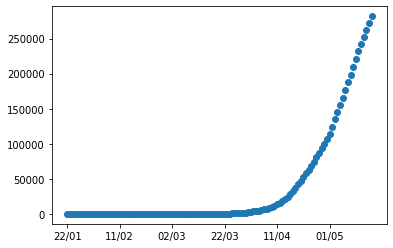

In [8]:
T = len(Russia_confirmed)
t = np.arange(T)
plt.plot(t, Russia_confirmed, 'o')
plt.xticks(t[0::20], dates[0::20])
pass

Наблюдается экспоненциальный рост. Удобнее использовать полулогарифмический масштаб: обычный линейный по горизонтальной оси и логарифмический по вертикальной.

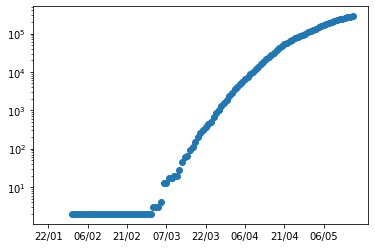

In [9]:
plt.semilogy(t, Russia_confirmed, 'o')
plt.xticks(t[::15], dates[::15])
pass

Начиная примерно с 6 марта до 6 апреля данные расположились вдоль прямой, что говорит об экспоненциальном росте. Это закономерное развитие эпидемии.

Выделим эти данные. Вначале найдем индекс, соответствующий дате 6 марта:

In [10]:
np.where(dates=='06/03'), np.where(dates=='1/04')

((array([44], dtype=int64),), (array([], dtype=int64),))

Выделяем данные:

In [11]:
t_start = 44
t_end = 70
C = Russia_confirmed[t_start:t_end]
D = Russia_deaths[t_start:t_end]
R = Russia_recovered[t_start:t_end]
I = Russia_confirmed[t_start:t_end] - Russia_deaths[t_start-1:t_end-1] - Russia_recovered[t_start-1:t_end-1]

`C`, `D`, `R` - это массивы, содержащие количества подтвержденных случаев, смертей и количество выздоровевших на каждый день.

`I` - количество зарегистрированных инфицированных.

Теперь можем изобразить эти данные:

In [12]:
T = len(C)
t = np.arange(T)
dates = dates[44:]

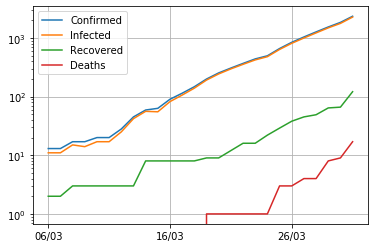

In [13]:
plt.semilogy(C, label='Confirmed')
plt.semilogy(I, label='Infected')
plt.semilogy(R, label='Recovered')
plt.semilogy(D, label='Deaths')
plt.legend()
plt.grid()
plt.xticks(t[0::10], dates[0::10])
pass

Графики `C` и `I` практически совпадают (особенно в логарифмическом масштабе), так как в начале эпидемии еще мало выздоровевших

## 4. Настройка параметров модели

Как уже отмечалось, количество зараженных `I` (и количество новых случаев `С`) в начале эпидемии растет экспоненциально: 

$$
I = I_0 e^{\alpha t}. \tag{$*$}
$$

Параметры $I_0$ и $\alpha$ это *модели экспоненциального роста* подберем по данным.

Рассмотрим два подхода.

### 4.1. Сведение к линейной задаче наименьших квадратов

Параметр $\alpha$ входит в модель нелинейно, поэтому напрямую метод наименьших квадратов в данном случае применить нельзя. Однако, прологарифмировав уравнение ($*$), получаем
$$
\ln I = \ln I_0 + \alpha t.
$$
Обозначим
$$
y = \ln I, \qquad y_0 = \ln I_0.
$$
Теперь зависимость выглядит так:
$$
y = y_0 + \alpha t.
$$
Теперь неизвестные параметры входят линейно.
Найдем из методом наименьших квадратов с помощью функции `polyfit`:

In [14]:
alpha, y0 = np.polyfit(t, np.log(I), 1)
alpha, y0

(0.22820502051800898, 2.107962936637556)

In [15]:
I0 = np.exp(y0)
I0

8.231456196449551

Изобразим график построенной линейной зависимости:

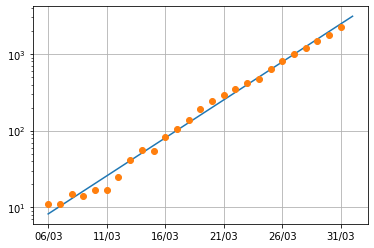

In [16]:
tt = np.linspace(0, T, 500)
II = I0*np.exp(alpha*tt)
plt.semilogy(tt, II)
plt.semilogy(t, I, 'o')
plt.grid()
plt.xticks(t[0::5], dates[0::5])

pass

### 4.2 Нелинейный метод наименьших квадратов

Другой способ подобрать значения параметров в зависимости ($*$) - использовать *нелинейный метод наименьших квадратов*.

Как и в линейном методе наименьших квадратов, будем минимизировать сумму квадратов невязок - отклонений предсказанного значения от истинного:
$$
\sum_{t=0}^{N-1} \left(I_0 e^{\alpha t} - I[t]\right)^2 \to \min
$$
где $I[t]$ - количество инфицированных в $t$-й день. Теперь, к сожалению, полученная задача минимизации не сводится к решению системы линейных уравнений (как в линейном методе наименьших квадратов), а решается численными методами.

Нелинейный метод найименьших квадратов реализован в функции `curve_fit` модуля `numpy.optimize`.

Вначале нужно создать функцию, реализующую искому зависимость:

In [17]:
def exponential_growth(t, I0, alpha):
    return I0 * np.exp(alpha*t)

Теперь вызываем функцию `curve_fit`:

In [18]:
params, _ = optimize.curve_fit(exponential_growth, t, I)
I0, alpha = params

In [19]:
I0, alpha

(12.02779235771787, 0.20910087329716093)

Значения параметров $\alpha$, найденные двумя способами, близки друг к другу.
Значения параметров $I_0$ отличаются заметнее.

Изобразим график зависимости, построенной вторым способом:

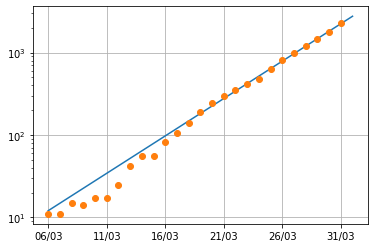

In [20]:
tt = np.linspace(0, T, 500)
II = exponential_growth(tt, I0, alpha)
plt.semilogy(tt, II)
plt.semilogy(t, I, 'o')
plt.grid()
plt.xticks(t[0::5], dates[0::5])

pass

Конечно же, для больш*и*х значений $I$ второй метод аппроксимирует данные лучше, чем первый метод.

Построенную зависимость можно использовать для предсказания развития эпидемии на ее начальном этапе.

В частности, делаем вывод, что сейчас каждые сутки количество зарегистрированных инфицированных увеличивается примерно на 23%: 

In [21]:
np.exp(alpha) - 1

0.232569325591361

Это примерно такое же (или даже меньшее) значение, как было в начале эпидемии в Италии, США и некоторых других странах. Введение карантина должно снизить эту скорость. Заметим, что если карантин не вводить, то экспоненциальный рост все равно прекратится и эпидемия закончится. Но карантин и другие меры сгладит эпидемиологическую кривую и уменьшит общее количество переболевших и количество больных в пик эпидемии, что очень важно. Карантин в России введен на более ранней стадии, чем в других странах.

По найденному параметру $\alpha$ можно оценить *интенсивность заражения* $\beta$ и *базовое репродуктивное число* $R_0$, если известна интенсивность выздоравливания $\gamma$.

$R0$ – среднее количество людей, инфицированных одним больным, если все контактные были восприимчивы;
$\beta$ – количество людей, инфицированных одним инфицированным человеком за единицу времени (за день)
$\gamma$ – доля от общего числа инфицированных, выздоровевших или умерших за сутки.

Например, если болезнь длится $8$ дней, то $\gamma = 1/8$.

$$
R_0 = \frac{\beta}{\gamma} = 1+ \frac{\alpha}{\gamma}
$$

In [22]:
gamma = 1/8
R0 = 1 + alpha/gamma
R0

2.6728069863772874

Зная найденные параметры, можно смоделировать дальнеший ход эпидемии, используя модель SIR и различные ее уточнения.